In [1]:
cd /workspace

/workspace


In [2]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=300, frameon=False, figsize=(3, 3), facecolor='white')




In [3]:
preprocesed_file = 'data/multispecies_concat_pp.h5ad'
results_file = 'data/multispecies_concat_clustered.h5ad'  # the file that will store the analysis results

In [4]:
adata1 = sc.read_10x_mtx('./data/mtxmultispecies/rat11_1a/',var_names='gene_symbols', cache=True)
adata2 = sc.read_10x_mtx('./data/mtxmultispecies/rat11_2a/',var_names='gene_symbols',cache=True)
adata3 = sc.read_10x_mtx('./data/mtxmultispecies/rat11_2b/',var_names='gene_symbols',cache=True)
adata4 = sc.read_10x_mtx('./data/mtxmultispecies/rat39_3b/',var_names='gene_symbols',cache=True)
adata5 = sc.read_10x_mtx('./data/mtxmultispecies/merged_dups/', var_names='gene_symbols',cache=True)


... reading from cache file cache/data-mtxmultispecies-rat11_1a-matrix.h5ad
... reading from cache file cache/data-mtxmultispecies-rat11_2a-matrix.h5ad
... reading from cache file cache/data-mtxmultispecies-rat11_2b-matrix.h5ad
... reading from cache file cache/data-mtxmultispecies-rat39_3b-matrix.h5ad
... reading from cache file cache/data-mtxmultispecies-merged_dups-matrix.h5ad


In [5]:
adata1

AnnData object with n_obs × n_vars = 1346 × 66425
    var: 'gene_ids', 'feature_types'

In [6]:
sample_list=['rat11_1a','rat11_2a','rat11_2b','rat39_3b','rat39_3ac']

In [7]:
adata = adata1.concatenate(adata2, adata3, adata4, adata5, index_unique=None, batch_key="sample", batch_categories=sample_list) #Merge the data

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [8]:
adata.obs_names_make_unique()
adata

AnnData object with n_obs × n_vars = 6361 × 66425
    obs: 'sample'
    var: 'gene_ids', 'feature_types'

In [9]:
set(adata.obs['sample'])

{'rat11_1a', 'rat11_2a', 'rat11_2b', 'rat39_3ac', 'rat39_3b'}

In [10]:
del adata1, adata2,adata3,adata4,adata5


In [11]:
sum(adata.var_names.str.startswith('GRCH38_MT-')), sum(adata.var_names.str.startswith('GRCH38')), sum(adata.var_names.str.startswith('Rnor6'))

(13, 33542, 32883)

normalizing counts per cell
    finished (0:00:00)


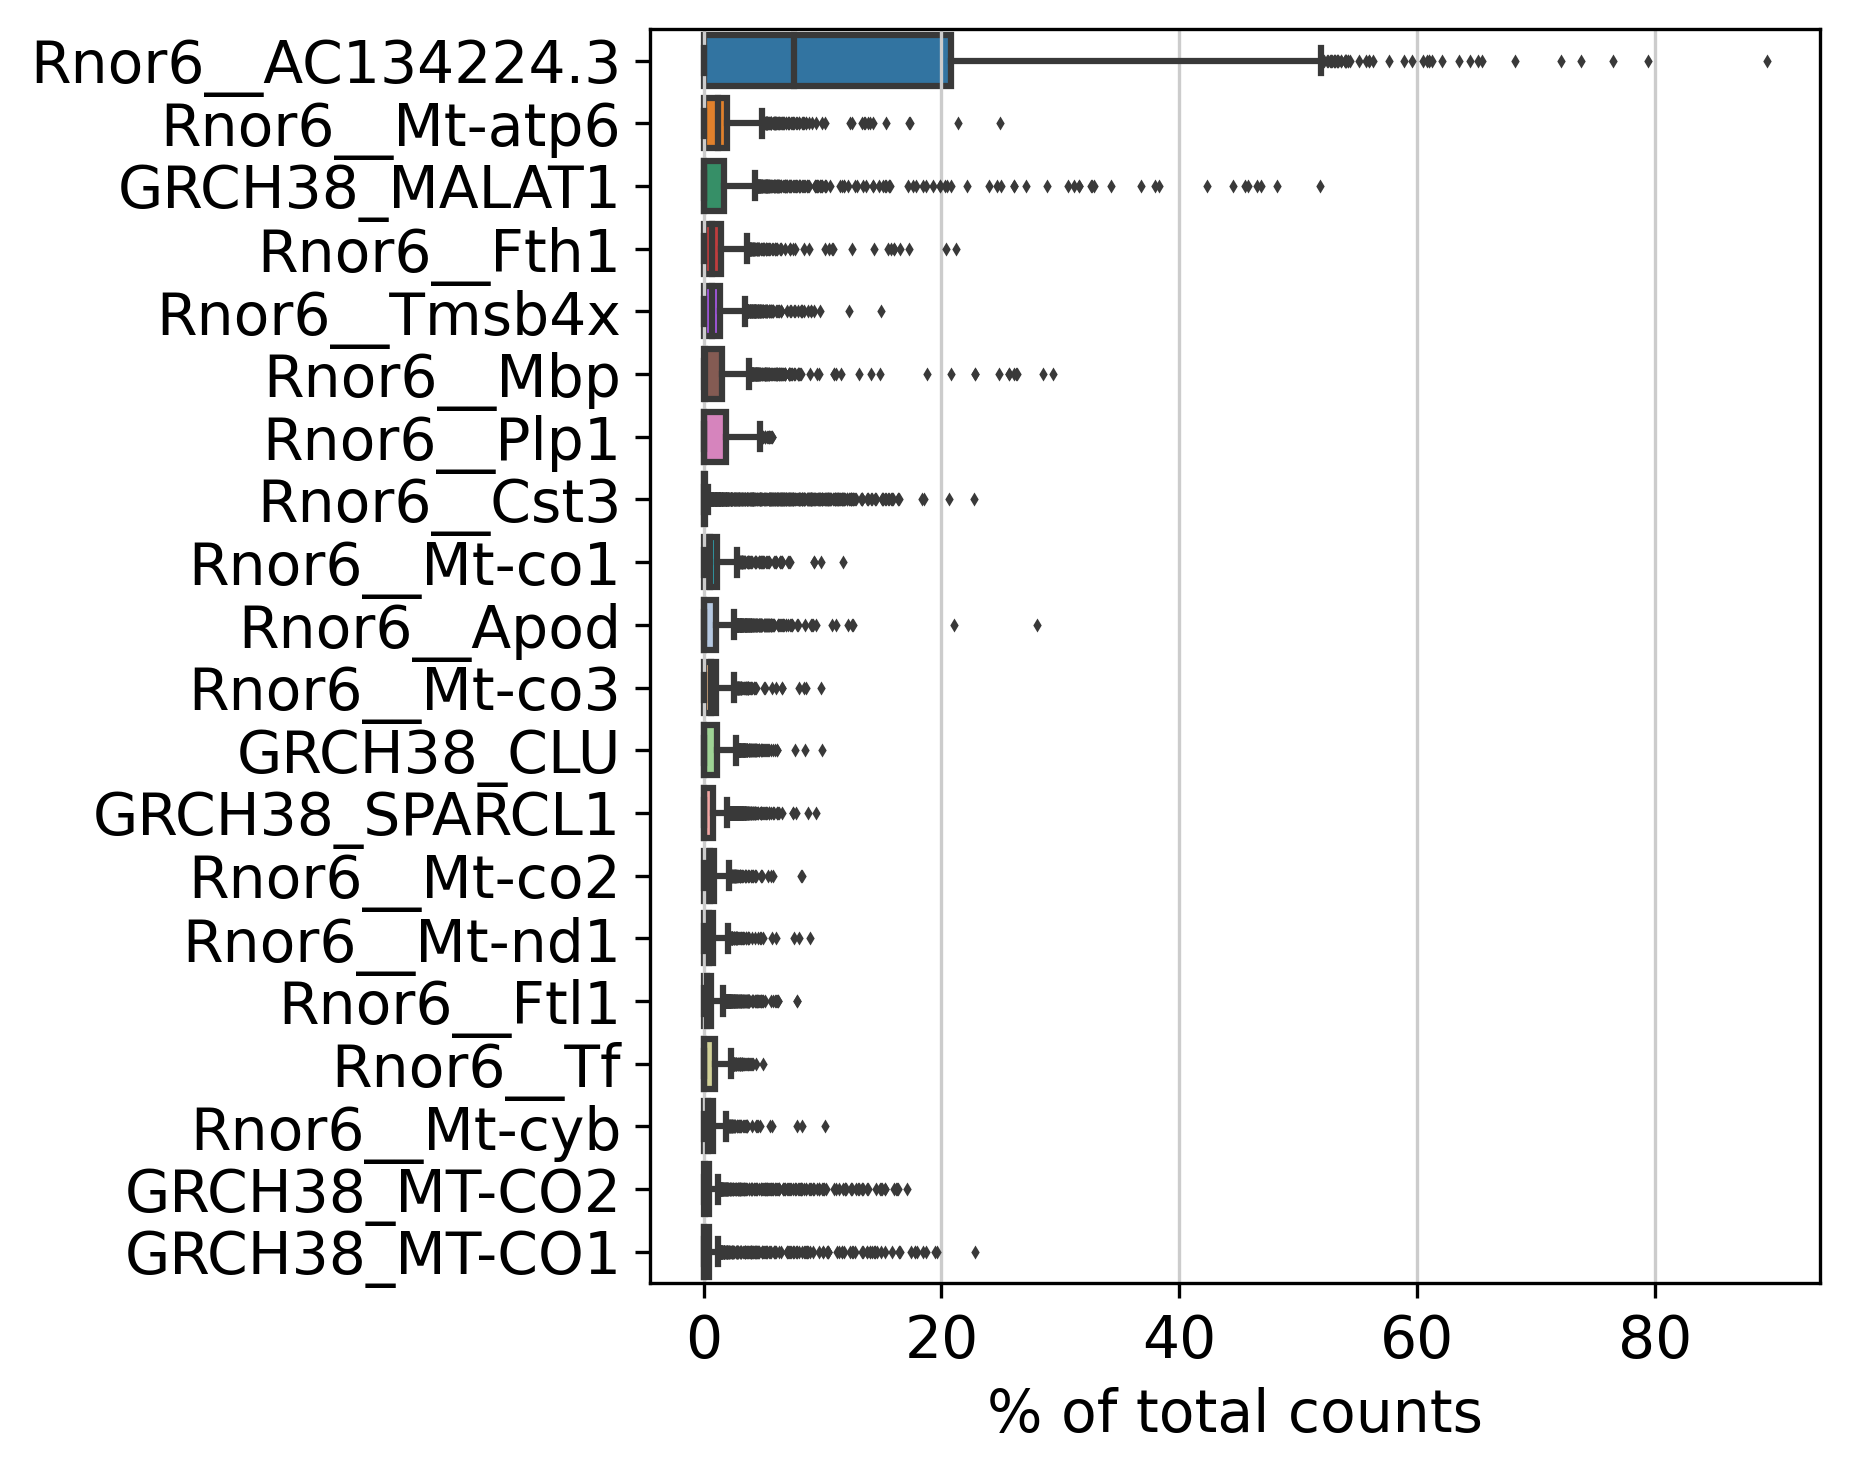

filtered out 66 cells that have less than 200 genes expressed
/opt/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
filtered out 34553 genes that are detected in less than 5 cells


AnnData object with n_obs × n_vars = 6295 × 31872
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_human', 'pct_counts_human', 'total_counts_rat', 'pct_counts_rat'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'human', 'rat', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20, )
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=5)
adata.var['mt'] = adata.var_names.str.startswith('GRCH38_MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['human'] = adata.var_names.str.startswith('GRCH38')  # annotate the group of mitochondrial genes as 'mt'
adata.var['rat'] = adata.var_names.str.startswith('Rnor6')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['human'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['rat'], percent_top=None, log1p=False, inplace=True)
adata

In [13]:
adata.obs['pct_counts_rat']

AAACCTGCAAGCGTAG-1    13.511560
AAACCTGCAGCCAGAA-1    97.843666
AAACCTGTCTGCAAGT-1    98.089523
AAACGGGCAACCGCCA-1    97.768761
AAAGATGAGGCATTGG-1    97.127831
                        ...    
GTCGGGTGTAAGCACG-1     2.941176
CGATGTAAGTACGATA-1    92.621353
TTAGTTCTCGCTGATA-1    91.252487
CCAATCCCAACACGCC-1     2.000000
ATCTGCCTCGTCGTTC-1     1.791045
Name: pct_counts_rat, Length: 6295, dtype: float32

... storing 'feature_types' as categorical


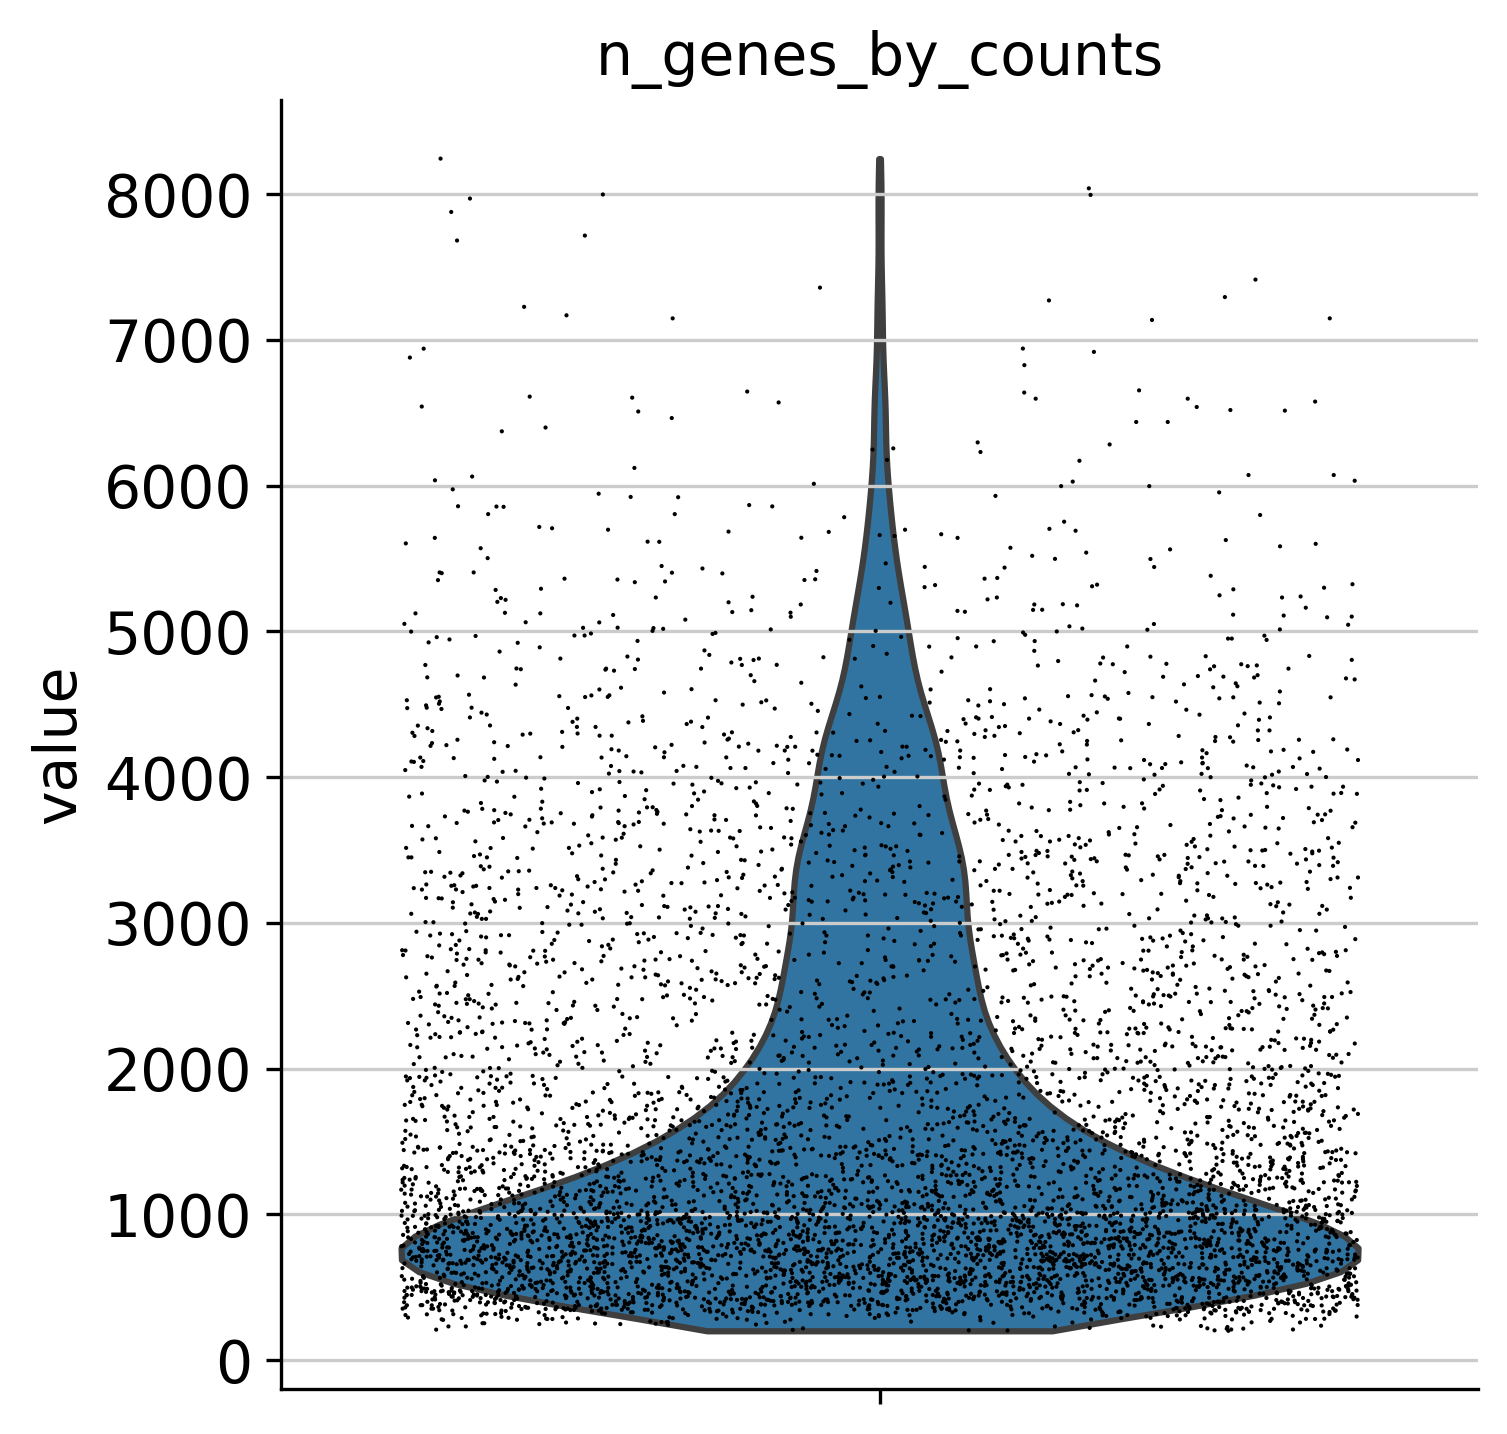

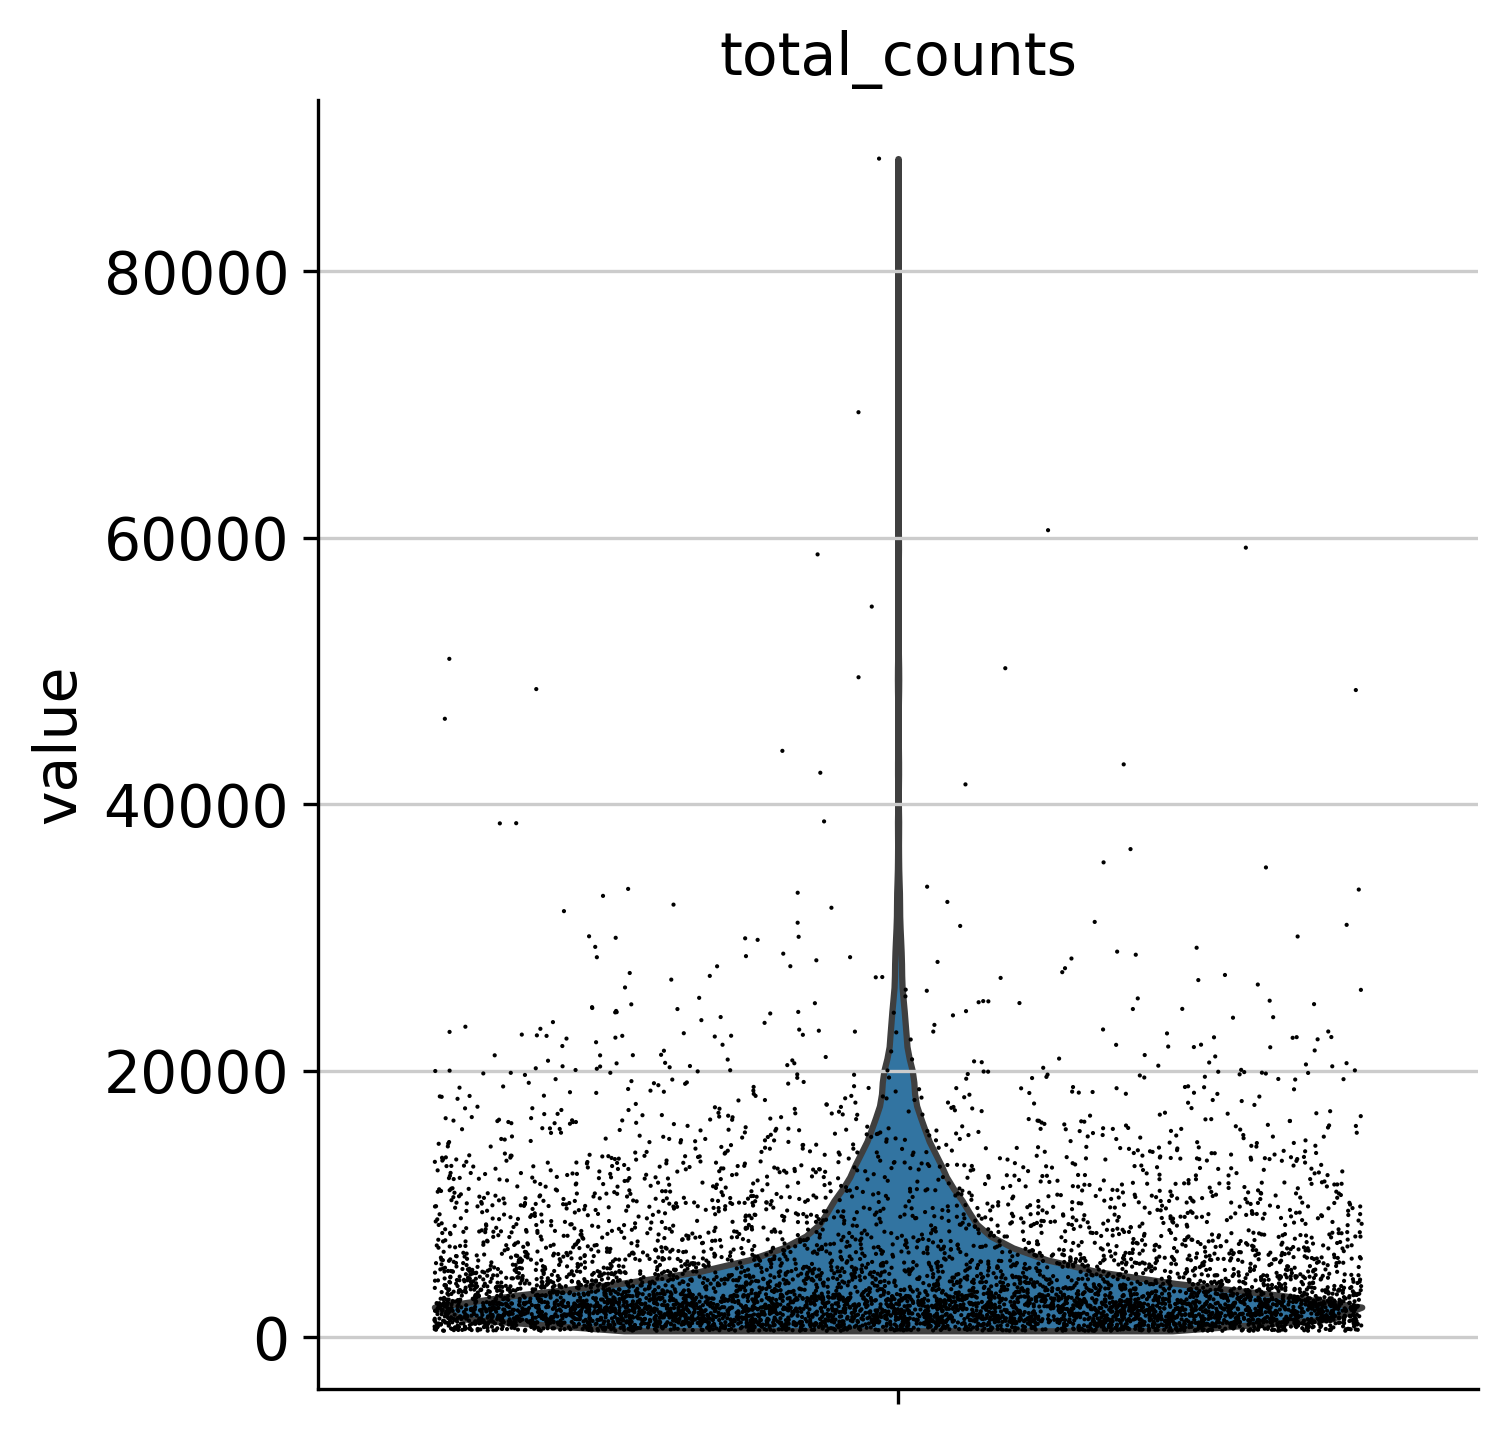

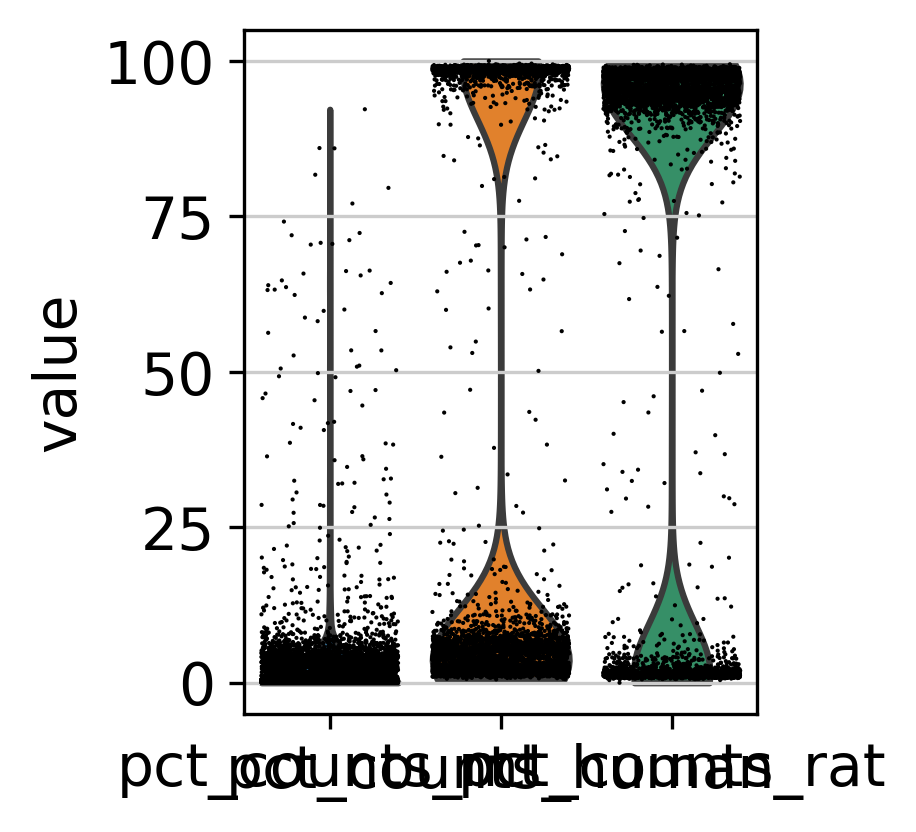

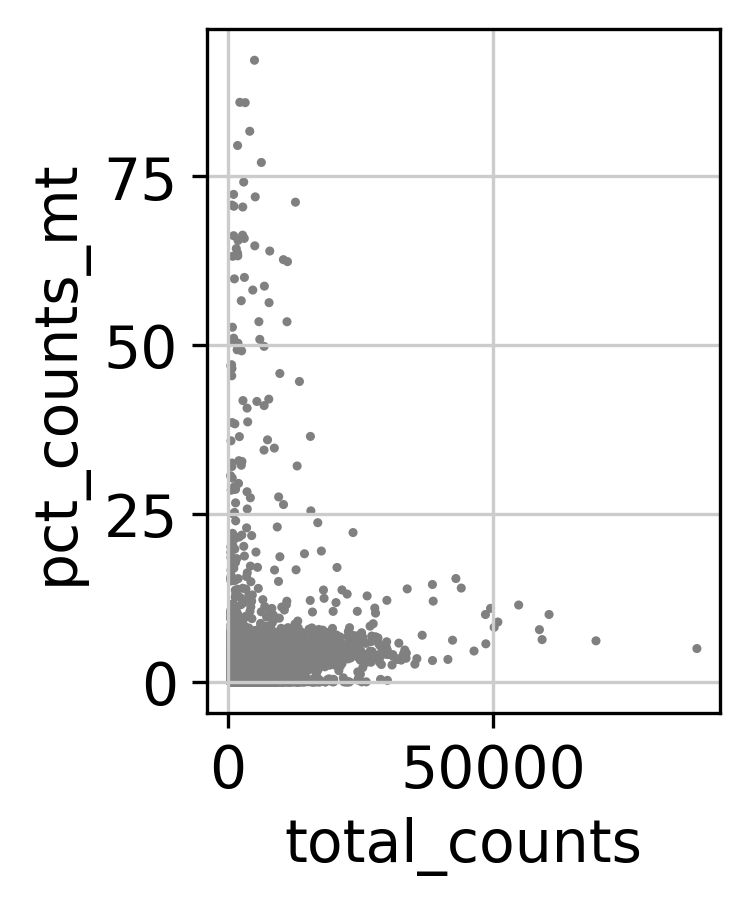

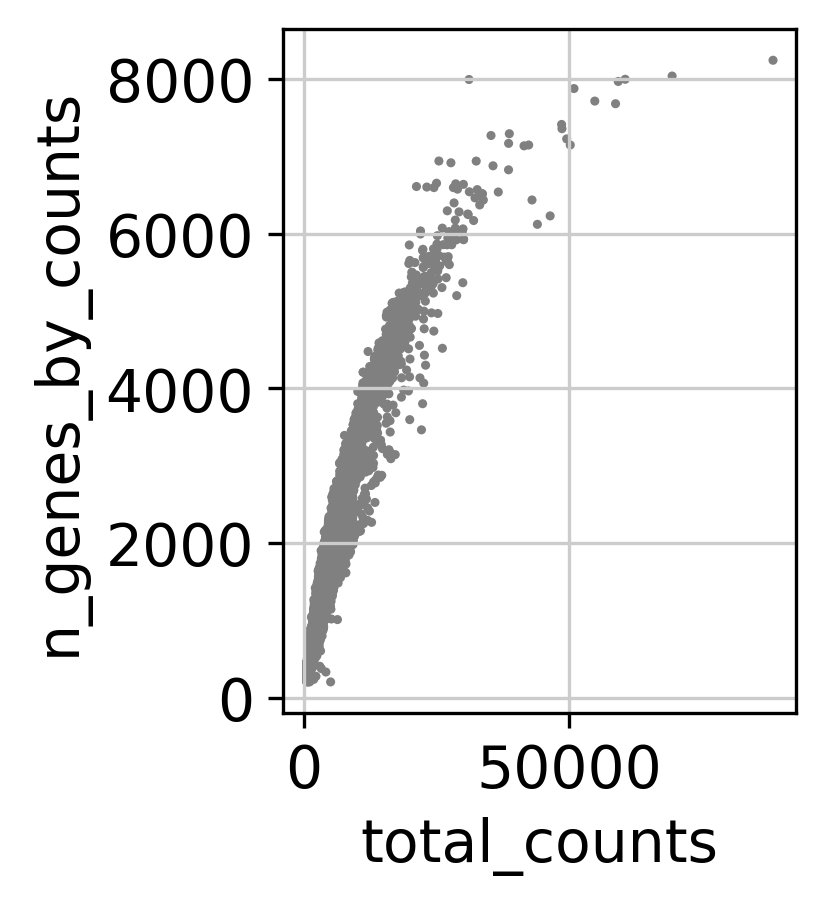

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4, multi_panel=True)
sc.pl.violin(adata, ['total_counts'], jitter=0.4, multi_panel=True)
sc.pl.violin(adata,['pct_counts_mt', 'pct_counts_human', 'pct_counts_rat'], jitter=0.4)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt') #Cut under 10% mit
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts') # cut under 5000 genes by counts

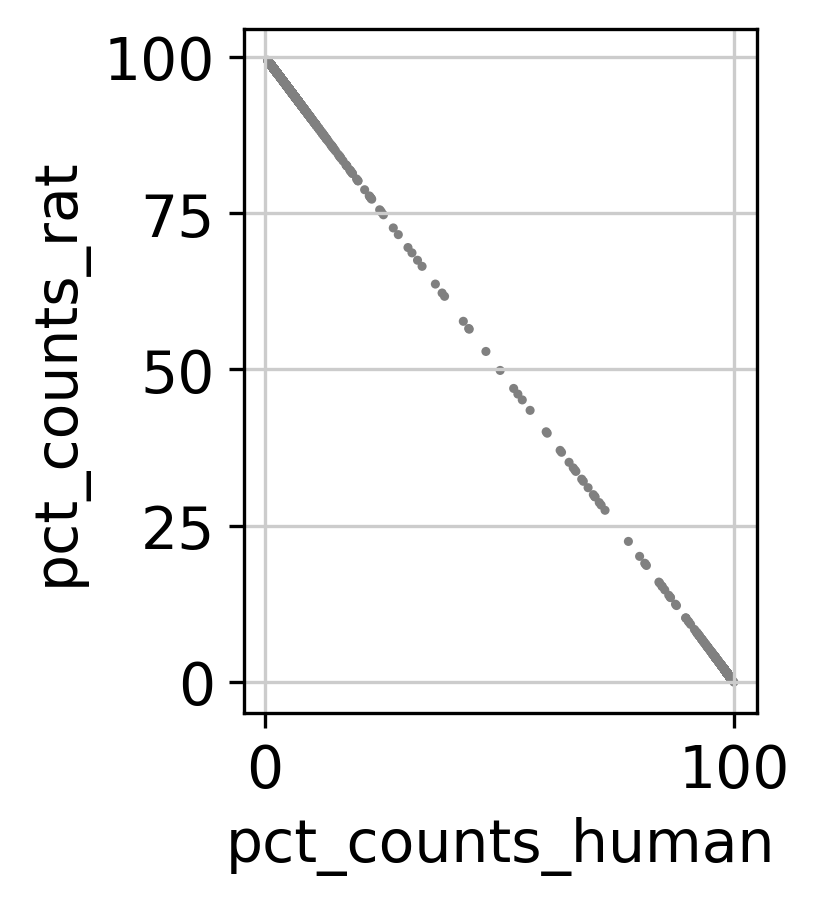

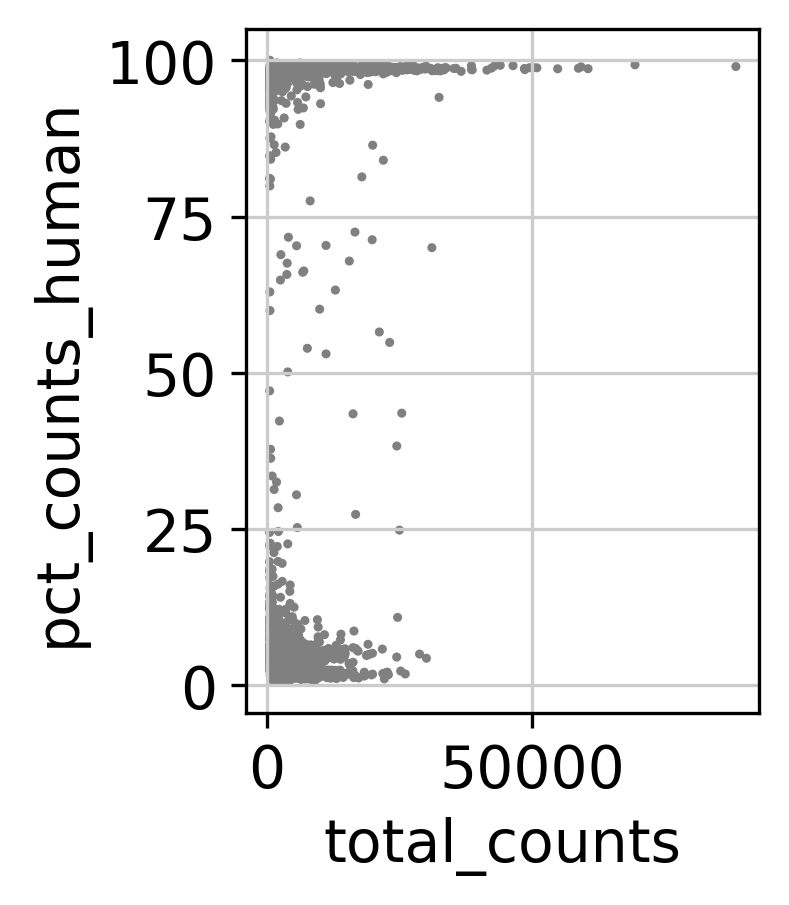

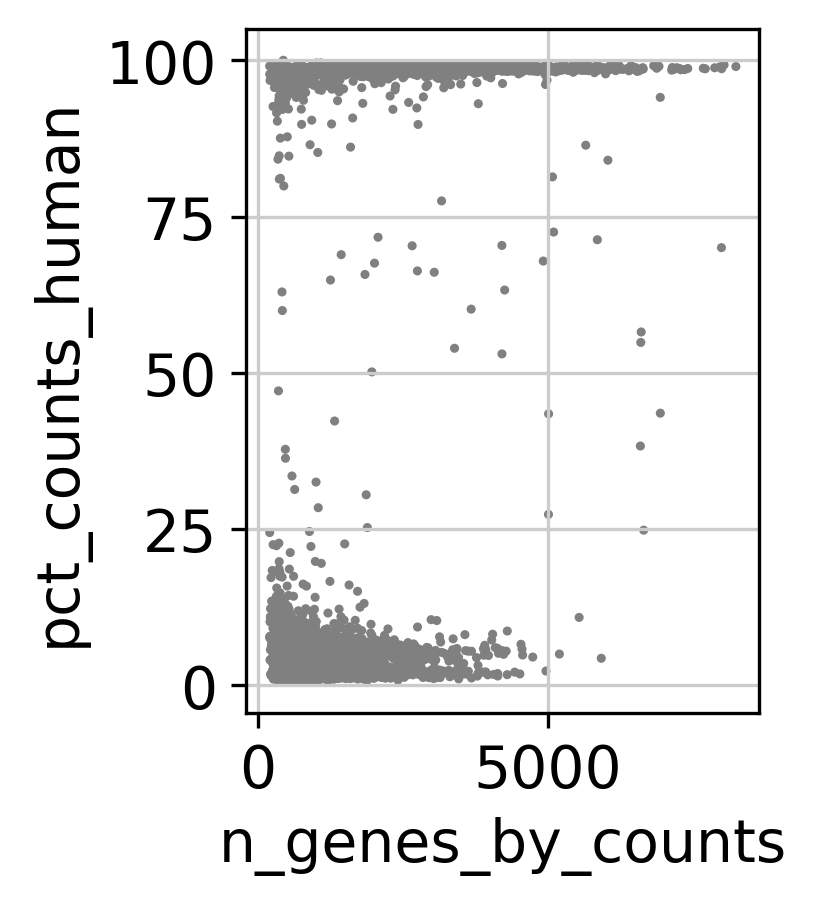

In [15]:
sc.pl.scatter(adata, x='pct_counts_human', y='pct_counts_rat')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_human')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_human')

In [16]:
adata

AnnData object with n_obs × n_vars = 6295 × 31872
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_human', 'pct_counts_human', 'total_counts_rat', 'pct_counts_rat'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'human', 'rat', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [17]:
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

/opt/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [18]:
human = adata[adata.obs.pct_counts_human > 90, : ]
rat =adata[adata.obs.pct_counts_rat > 90, : ]

/opt/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [19]:
adata = human.concatenate(rat,index_unique=None, batch_key='species', batch_categories=['human','rat'] )

In [20]:
new_vars=[]
print(len(adata.var_names))
for gene in adata.var_names:
    new_varname = gene.split('_',1)[1]
    if new_varname.startswith('_'):
        new_vars.append(new_varname.split('_',1)[1])
    else :
        new_vars.append(new_varname)
print(len(new_vars))

31872
31872


In [21]:
new_vars[1:5],new_vars[31867:] 

(['FAM87B', 'LINC00115', 'FAM41C', 'AL645608.1'],
 ['LOC103694855-1',
  'LOC100911132',
  'Anp32a-1',
  'LOC100911422',
  'AABR07022393.1'])

In [22]:
adata.var['Orig_VarNames'] = adata.var_names
adata.var_names = new_vars
adata

AnnData object with n_obs × n_vars = 5414 × 31872
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_human', 'pct_counts_human', 'total_counts_rat', 'pct_counts_rat', 'species'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'human', 'rat', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'Orig_VarNames'

In [23]:
adata.var.Orig_VarNames[1:5]#; len(adata.var.orig_VarNames)

FAM87B            GRCH38_FAM87B
LINC00115      GRCH38_LINC00115
FAM41C            GRCH38_FAM41C
AL645608.1    GRCH38_AL645608.1
Name: Orig_VarNames, dtype: object

In [24]:
adata.var_names[1:5]

Index(['FAM87B', 'LINC00115', 'FAM41C', 'AL645608.1'], dtype='object')

In [25]:
#There is barely any overlap, will have to analyse them separetely and compare celltypes

In [26]:
del human, rat
adata.obs_names_make_unique()

In [27]:
sc.pp.normalize_total(adata, target_sum=1e4)


normalizing counts per cell
    finished (0:00:00)


In [28]:
sc.pp.log1p(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


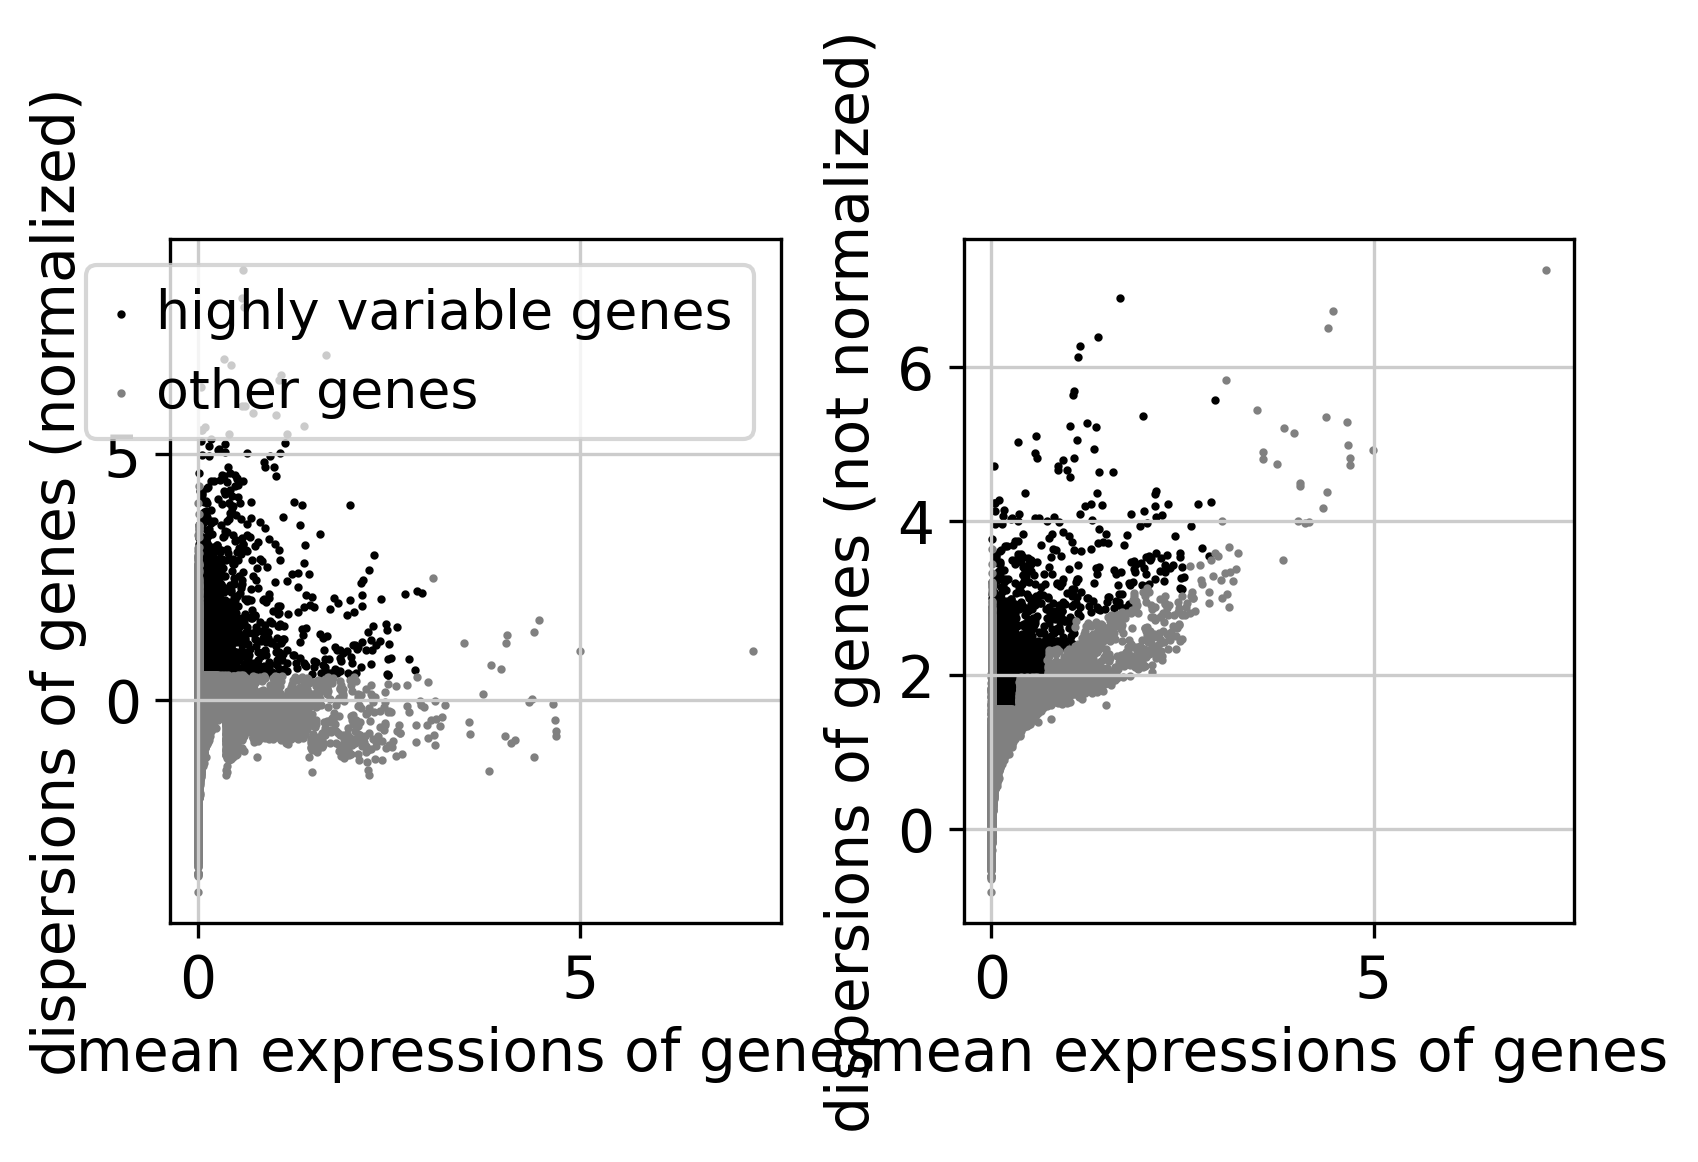

In [29]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [30]:
adata.raw = adata

In [31]:
adata = adata[:, adata.var.highly_variable]

In [32]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:21)


In [33]:
sc.pp.scale(adata, max_value=10)

In [34]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
/opt/miniconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    with n_comps=50
    finished (0:00:05)


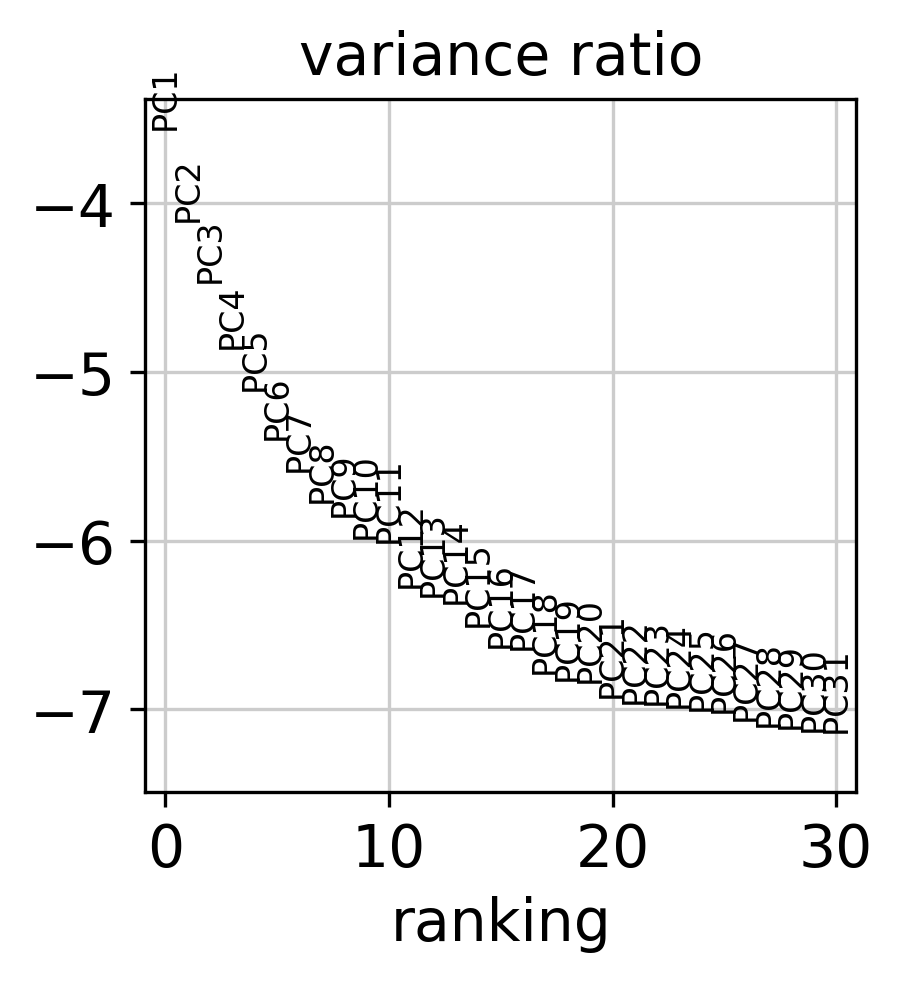

In [35]:
sc.pl.pca_variance_ratio(adata, log=True)

In [36]:
adata

AnnData object with n_obs × n_vars = 5414 × 7974
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_human', 'pct_counts_human', 'total_counts_rat', 'pct_counts_rat', 'species'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'human', 'rat', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'Orig_VarNames', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [37]:
#Compute neighborhood graph 
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


In [38]:
sc.tl.leiden(adata, resolution = 0.2, key_added = 'leiden_0.2')

running Leiden clustering
    finished: found 11 clusters and added
    'leiden_0.2', the cluster labels (adata.obs, categorical) (0:00:00)


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


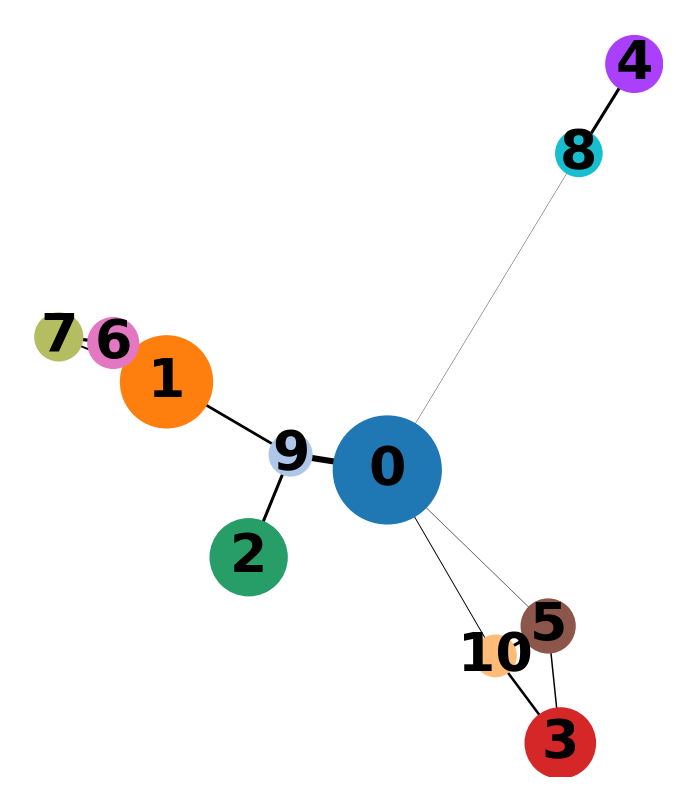

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


In [39]:
# Embed it
#Prevent cluster rules vilations
sc.tl.paga(adata, groups= 'leiden_0.2')
sc.pl.paga(adata)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [40]:
adata

AnnData object with n_obs × n_vars = 5414 × 7974
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_human', 'pct_counts_human', 'total_counts_rat', 'pct_counts_rat', 'species', 'leiden_0.2'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'human', 'rat', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'Orig_VarNames', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_0.2_sizes', 'leiden_0.2_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


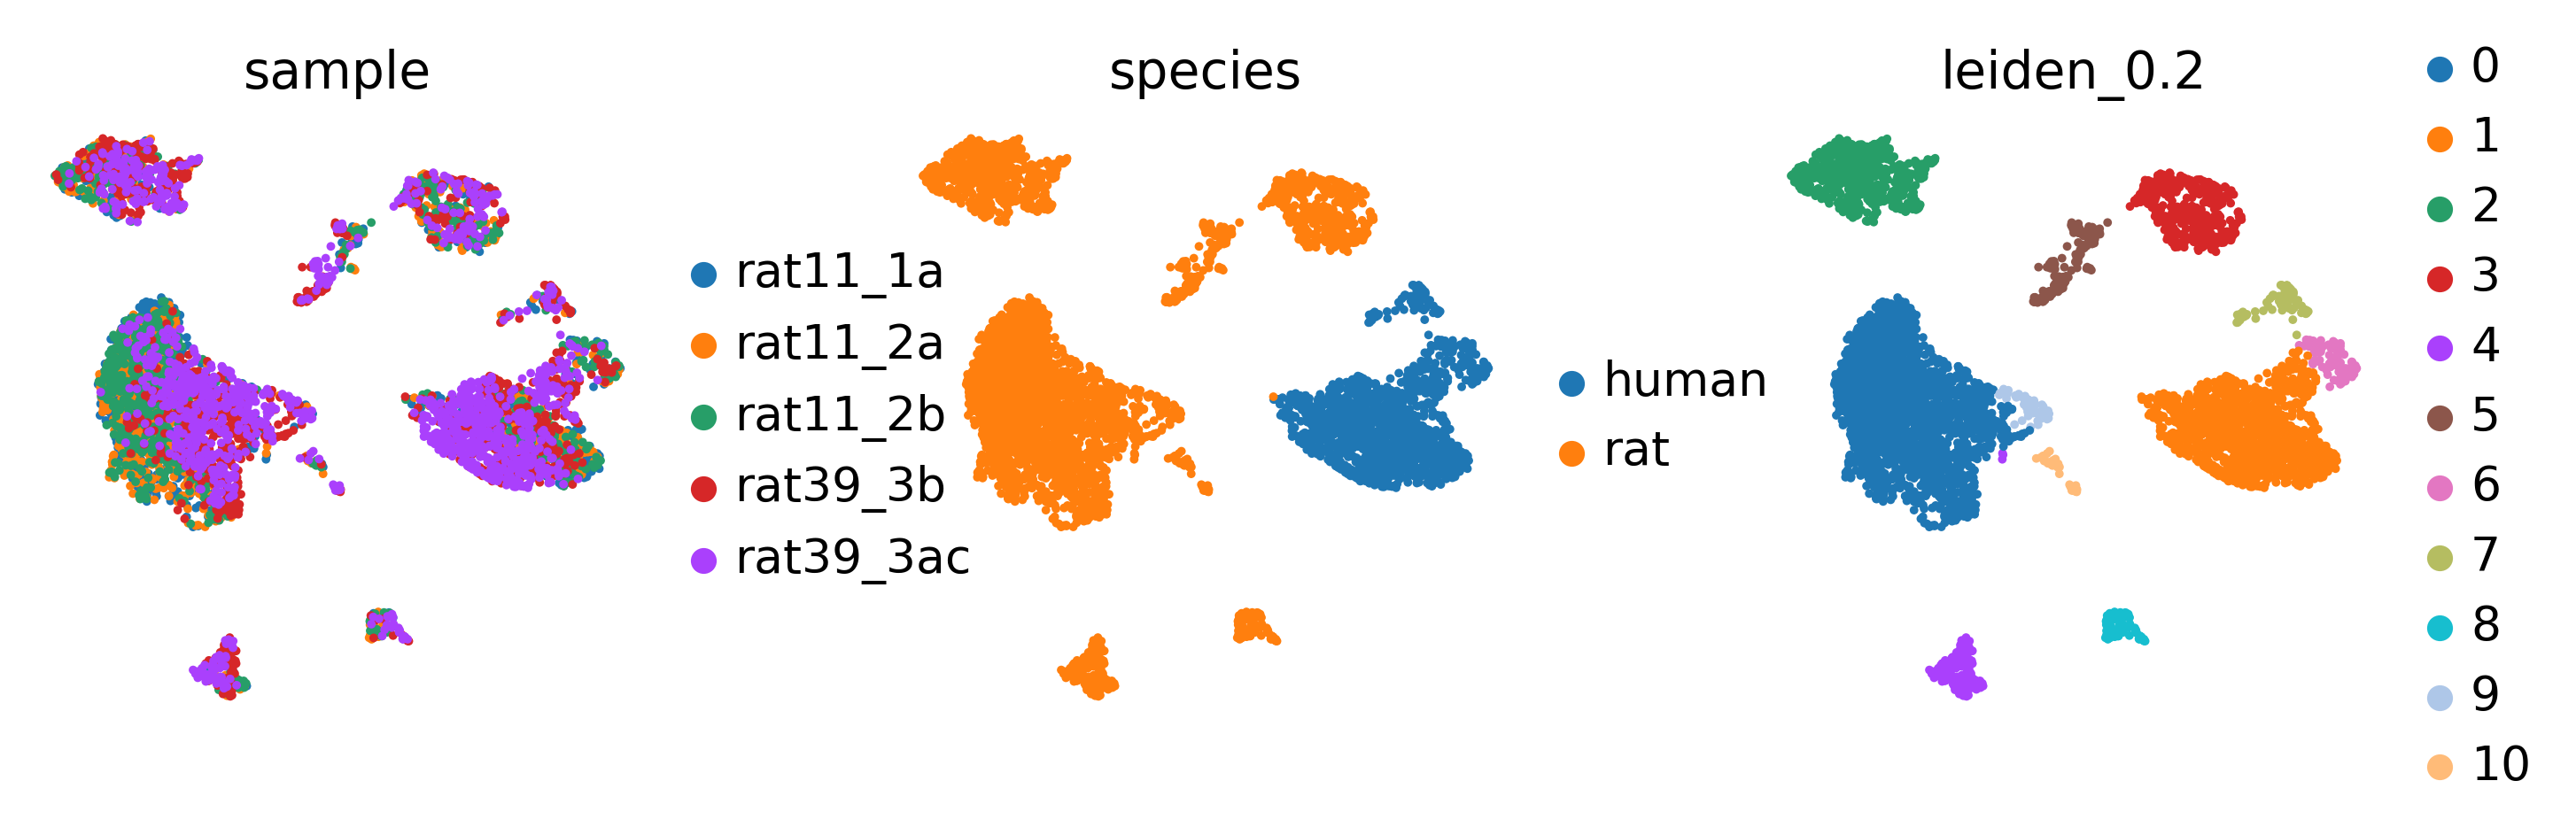

In [41]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['sample', 'species','leiden_0.2'])

In [42]:
adatapp = adata.copy()

In [43]:
adatapp

AnnData object with n_obs × n_vars = 5414 × 7974
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_human', 'pct_counts_human', 'total_counts_rat', 'pct_counts_rat', 'species', 'leiden_0.2'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'human', 'rat', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'Orig_VarNames', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_0.2_sizes', 'leiden_0.2_colors', 'umap', 'sample_colors', 'species_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [44]:
adatapp.obs.drop(adatapp.obs.columns.difference(['sample','species']), 1, inplace=True)
adatapp.var.drop(adatapp.var.columns.difference(['gene_ids','Orig_VarNames']), 1, inplace=True)
del adatapp.obsm, adatapp.uns, adatapp.varm, adatapp.obsp

In [45]:
adatapp

AnnData object with n_obs × n_vars = 5414 × 7974
    obs: 'sample', 'species'
    var: 'gene_ids', 'Orig_VarNames'

In [46]:
adata

AnnData object with n_obs × n_vars = 5414 × 7974
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_human', 'pct_counts_human', 'total_counts_rat', 'pct_counts_rat', 'species', 'leiden_0.2'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'human', 'rat', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'Orig_VarNames', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_0.2_sizes', 'leiden_0.2_colors', 'umap', 'sample_colors', 'species_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [47]:
adata.write(results_file)
adatapp.write(preprocesed_file)